In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

In [ ]:
import os

# Define dataset path
data_directory = "/content/drive/MyDrive/archive (4)-20250320T104743Z-001/archive (4)/The IQ-OTHNCCD lung cancer dataset"

# List only the folders (subdirectories) inside the dataset directory
folders = [folder for folder in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, folder))]

# Print folder names
print("Folders in the dataset directory:")
for folder in folders:
    print(folder)


Folders in the dataset directory:
Malignant cases
Normal cases
Bengin cases


In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

benign_dirs = [
    r'/content/drive/MyDrive/archive (4)-20250320T104743Z-001/archive (4)/The IQ-OTHNCCD lung cancer dataset/Bengin cases'
]

Malignant_dir = [ r'/content/drive/MyDrive/archive (4)-20250320T104743Z-001/archive (4)/The IQ-OTHNCCD lung cancer dataset/Malignant cases']

Normal_dirs = [
    r'/content/drive/MyDrive/archive (4)-20250320T104743Z-001/archive (4)/The IQ-OTHNCCD lung cancer dataset/Normal cases'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/archive (4)-20250320T10...  benign
1  /content/drive/MyDrive/archive (4)-20250320T10...  benign
2  /content/drive/MyDrive/archive (4)-20250320T10...  benign
3  /content/drive/MyDrive/archive (4)-20250320T10...  benign
4  /content/drive/MyDrive/archive (4)-20250320T10...  benign
labels
Malignant    561
Normal       416
benign       120
Name: count, dtype: int64


In [ ]:
Lung_df.shape

(1097, 2)

In [ ]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(877, 2)
(330, 2)
(220, 2)
(767, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 877 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


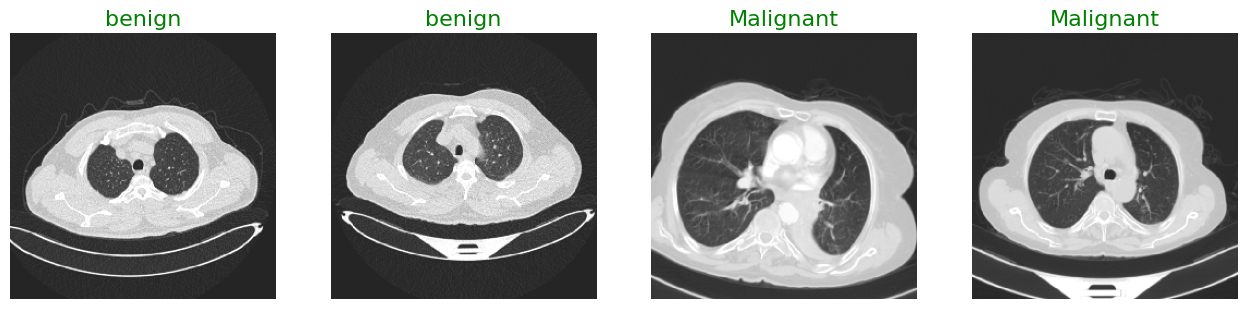

In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

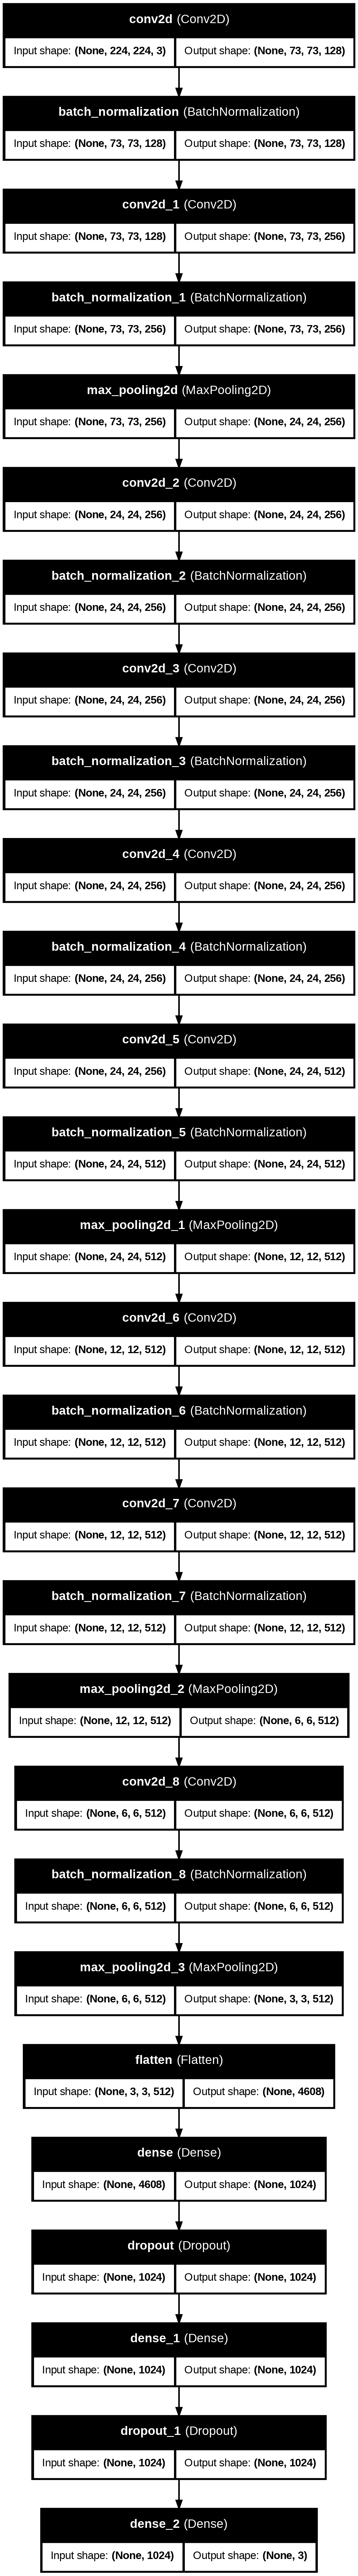

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 717s 3s/step - accuracy: 0.5211 - loss: 1.8315 - val_accuracy: 0.6136 - val_loss: 0.9002
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.6876 - loss: 0.9157 - val_accuracy: 0.8136 - val_loss: 0.4409
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7912 - loss: 0.5576 - val_accuracy: 0.8864 - val_loss: 0.2936
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.8888 - loss: 0.3007 - val_accuracy: 0.9318 - val_loss: 0.1713
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.8919 - loss: 0.2721 - val_accuracy: 0.9000 - val_loss: 0.1839
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9338 - loss: 0.1586 - val_accuracy: 0.9182 - val_loss: 0.2009
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9503 - loss: 0.1388 - val_accuracy: 0.9682 - val_loss: 0.0652
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.9714 - loss: 0.0867 - v

In [ ]:
model.evaluate(test, verbose=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9967 - loss: 0.0178


[0.022604918107390404, 0.9939393997192383]

In [ ]:
model.save("Lung_Model.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


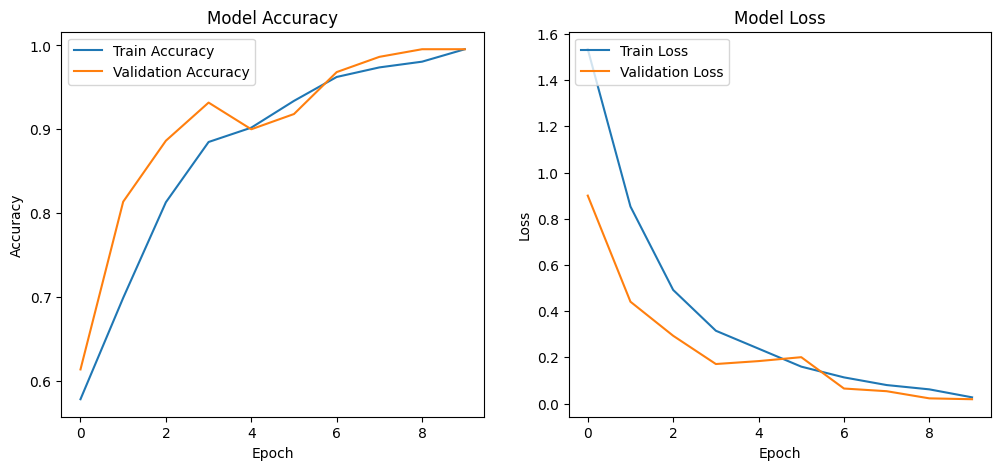

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy & loss side by side
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
# print(classification_report(y_test, pred2))
# print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

accuracy = accuracy_score(y_test, pred2) # Pass the true and predicted labels directly
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 99.39%


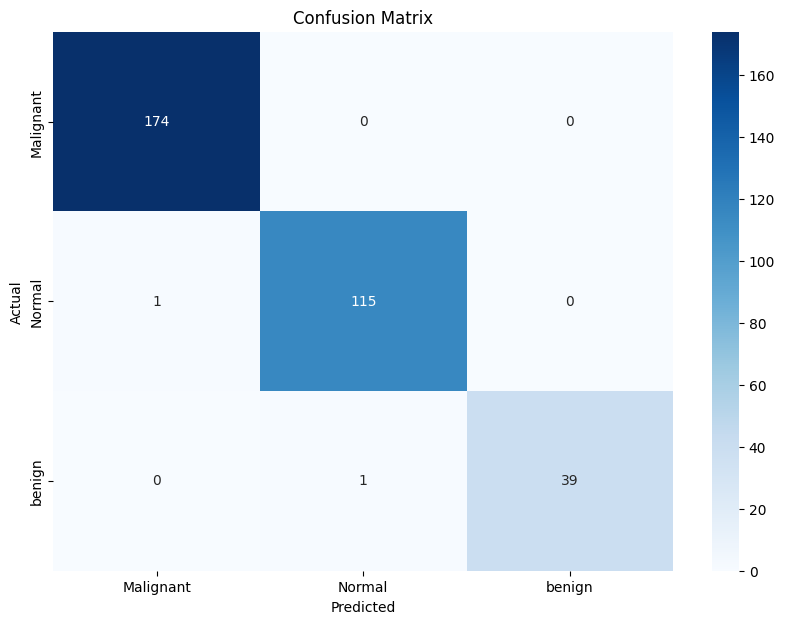

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Malignant', 'Normal', 'benign']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [ ]:
y_test = test.classes  # Fixing incorrect label extraction
print(classification_report(y_test, pred))

print(f"Final Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")

print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       174
           1       0.99      0.99      0.99       116
           2       1.00      0.97      0.99        40

    accuracy                           0.99       330
   macro avg       1.00      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

Final Training Accuracy: 99.54%
Final Validation Accuracy: 99.55%
Final Training Loss: 0.0271
Final Validation Loss: 0.0189


# **DenseNet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Fix this size
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=True
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Fix this size
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Fix this size
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)


Found 877 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load DenseNet121 with pretrained ImageNet weights, excluding the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers for better fine-tuning
for layer in base_model.layers[-100:]:  # Increased from 50 to 100 layers
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.6),  # Increased dropout for better generalization

    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(3, activation='softmax')  # Assuming 3 classes
])

# Compile the model with a lower learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00003),  # Lowered learning rate for better fine-tuning
    metrics=['accuracy']
)

# Learning rate reduction callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Print model summary
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,619,587 (32.88 MB)

 Trainable params: 8,532,867 (32.55 MB)

 Non-trainable params: 86,720 (338.75 KB)

In [ ]:
# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping # Importing necessary classes

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

In [ ]:
# Train the model
history = model.fit(
    train,
    epochs=30,  # Increase epochs
    validation_data=val,
    verbose=1,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 322s 528ms/step - accuracy: 0.4532 - loss: 3.2289 - val_accuracy: 0.6682 - val_loss: 2.3568 - learning_rate: 3.0000e-05
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.5711 - loss: 2.7704 - val_accuracy: 0.8045 - val_loss: 1.9965 - learning_rate: 3.0000e-05
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.6897 - loss: 2.3877 - val_accuracy: 0.8455 - val_loss: 1.8781 - learning_rate: 3.0000e-05
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.6949 - loss: 2.3777 - val_accuracy: 0.8136 - val_loss: 1.9502 - learning_rate: 3.0000e-05
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.7351 - loss: 2.2270 - val_accuracy: 0.8500 - val_loss: 1.8267 - learning_rate: 3.0000e-05
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.7419 - loss: 2.2003 - val_accuracy: 0.8409 - val_loss: 1.7423 - learning_rate: 3.0000e-05
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/s

In [ ]:
# Evaluate the model
model.evaluate(test, verbose=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9665 - loss: 1.2517


[1.234675645828247, 0.978787899017334]

In [ ]:
# Save the model
model.save("Lung_Model_DenseNet.h5")

In [ ]:
# Predictions
pred = model.predict(test)
pred = np.argmax(pred, axis=1) # Pick class with highest probability


83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step


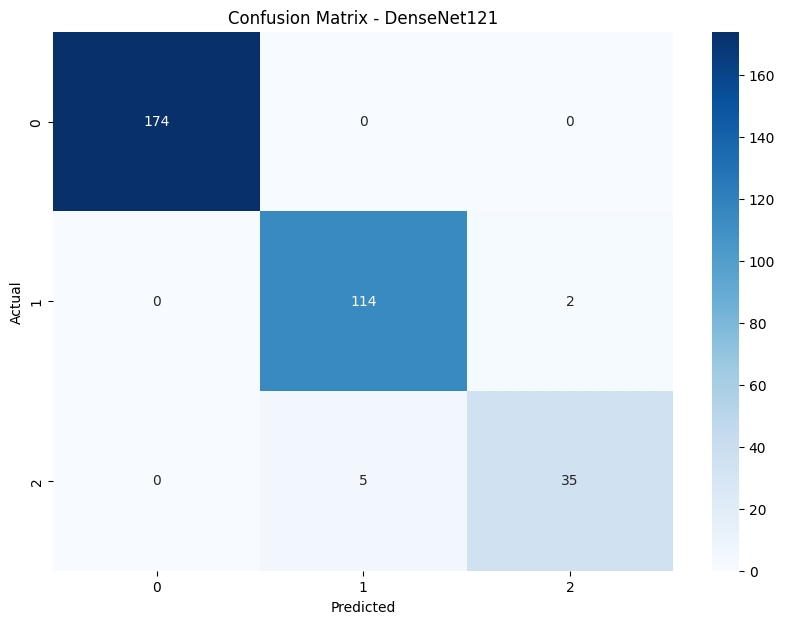

In [ ]:
# Confusion matrix
cm = confusion_matrix(test.classes, pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DenseNet121")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Generate the classification report
print(classification_report(test.classes, pred))

# Calculate and print the accuracy
densenet_accuracy = accuracy_score(test.classes, pred)
print(f"Model Accuracy: {densenet_accuracy * 100:.2f}%")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       0.96      0.98      0.97       116
           2       0.95      0.88      0.91        40

    accuracy                           0.98       330
   macro avg       0.97      0.95      0.96       330
weighted avg       0.98      0.98      0.98       330

Model Accuracy: 97.88%


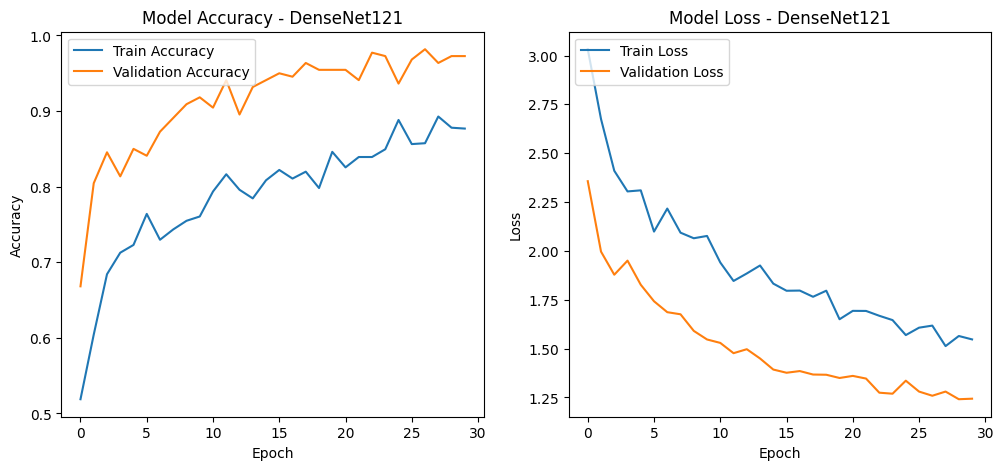

In [ ]:
# Accuracy & Loss plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - DenseNet121')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - DenseNet121')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# **EfficientNetB3**

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

In [ ]:
# Image data generator with preprocessing specific to EfficientNet
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(300, 300),  # EfficientNet requires larger images
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=True
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(300, 300),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(300, 300),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)


Found 877 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
# Load EfficientNetB3 with pretrained ImageNet weights
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Unfreeze top layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy']
)

# Print model summary
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,889,906 (49.17 MB)

 Trainable params: 12,799,531 (48.83 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)


In [ ]:
# Train the model
history = model.fit(
    train,
    epochs=30,
    validation_data=val,
    verbose=1,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 211s 381ms/step - accuracy: 0.4669 - loss: 1.4763 - val_accuracy: 0.7727 - val_loss: 0.6835 - learning_rate: 5.0000e-05
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.6904 - loss: 0.9735 - val_accuracy: 0.8045 - val_loss: 0.6067 - learning_rate: 5.0000e-05
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.7021 - loss: 0.9268 - val_accuracy: 0.8182 - val_loss: 0.4789 - learning_rate: 5.0000e-05
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.7432 - loss: 0.8880 - val_accuracy: 0.8727 - val_loss: 0.3457 - learning_rate: 5.0000e-05
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.7664 - loss: 0.7318 - val_accuracy: 0.9273 - val_loss: 0.2330 - learning_rate: 5.0000e-05
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.7154 - loss: 0.8588 - val_accuracy: 0.9273 - val_loss: 0.2167 - learning_rate: 5.0000e-05
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/s

In [ ]:
# Evaluate the model
model.evaluate(test, verbose=1)


83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9740 - loss: 0.0544


[0.05854933708906174, 0.9727272987365723]

In [ ]:
# Save the model
model.save("Lung_Model_EfficientNetB3.h5")


In [ ]:
# Predictions
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step


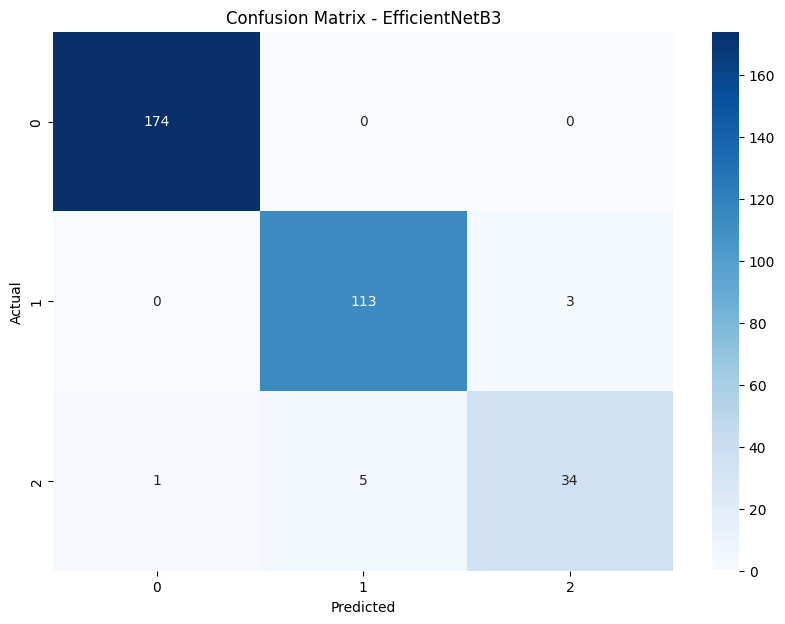

In [ ]:
# Confusion matrix
cm = confusion_matrix(test.classes, pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - EfficientNetB3")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Generate the classification report
print(classification_report(test.classes, pred))

# Calculate and print the accuracy
EfficientNetB3_accuracy = accuracy_score(test.classes, pred)
print(f"Model Accuracy: {EfficientNetB3_accuracy * 100:.2f}%")


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       174
           1       0.96      0.97      0.97       116
           2       0.92      0.85      0.88        40

    accuracy                           0.97       330
   macro avg       0.96      0.94      0.95       330
weighted avg       0.97      0.97      0.97       330

Model Accuracy: 97.27%


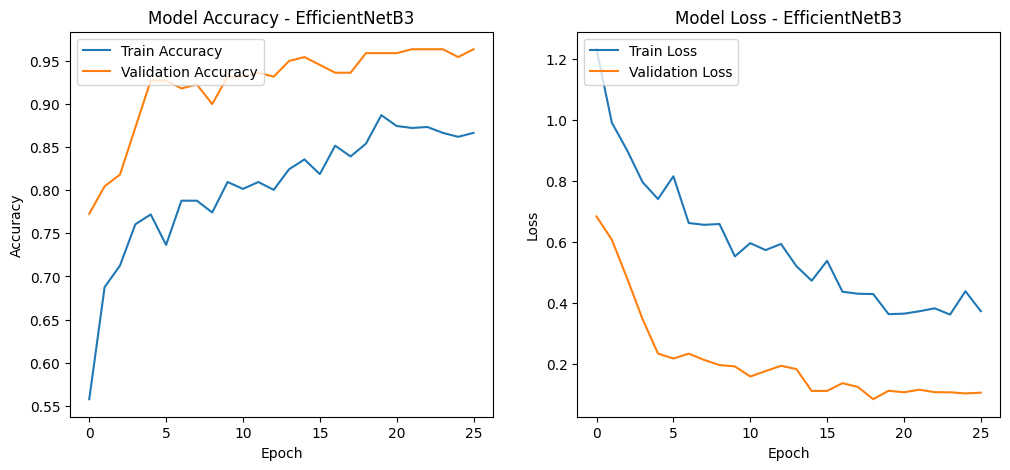

In [ ]:
# Accuracy & Loss plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - EfficientNetB3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - EfficientNetB3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# **ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Define ImageDataGenerator for preprocessing
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Load training, validation, and test data
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=True
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)


Found 877 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.


In [ ]:
# Load ResNet50 pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers for feature extraction
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build ResNet50-based model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00005),  # Fine-tuning with low learning rate
    metrics=['accuracy']
)

# Print model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,218,371 (100.02 MB)

 Trainable params: 19,578,115 (74.68 MB)

 Non-trainable params: 6,640,256 (25.33 MB)

In [ ]:
# Define callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)


In [ ]:
# Train the model
history = model.fit(
    train,
    epochs=30,
    validation_data=val,
    verbose=1,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - accuracy: 0.5597 - loss: 1.2231 - val_accuracy: 0.8682 - val_loss: 0.3831 - learning_rate: 5.0000e-05
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.7386 - loss: 0.7149 - val_accuracy: 0.9000 - val_loss: 0.2538 - learning_rate: 5.0000e-05
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7643 - loss: 0.6539 - val_accuracy: 0.8727 - val_loss: 0.3005 - learning_rate: 5.0000e-05
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7932 - loss: 0.5611 - val_accuracy: 0.9273 - val_loss: 0.2044 - learning_rate: 5.0000e-05
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7828 - loss: 0.6479 - val_accuracy: 0.9455 - val_loss: 0.1719 - learning_rate: 5.0000e-05
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.8576 - loss: 0.3728 - val_accuracy: 0.9682 - val_loss: 0.0920 - learning_rate: 5.0000e-05
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/st

In [ ]:
# Evaluate the model
model.evaluate(test, verbose=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9948 - loss: 0.0134


[0.01179357897490263, 0.9969696998596191]

In [ ]:
# Save the trained model
model.save("Lung_Model_ResNet.h5")

In [ ]:
# Predictions
pred = model.predict(test)
pred = np.argmax(pred, axis=1)


83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step


In [ ]:
# Generate classification report
print(classification_report(test.classes, pred))

# Calculate accuracy
ResNet50_accuracy = accuracy_score(test.classes, pred)
print(f"Model Accuracy: {ResNet50_accuracy * 100:.2f}%")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      0.99      1.00       116
           2       0.98      1.00      0.99        40

    accuracy                           1.00       330
   macro avg       0.99      1.00      0.99       330
weighted avg       1.00      1.00      1.00       330

Model Accuracy: 99.70%


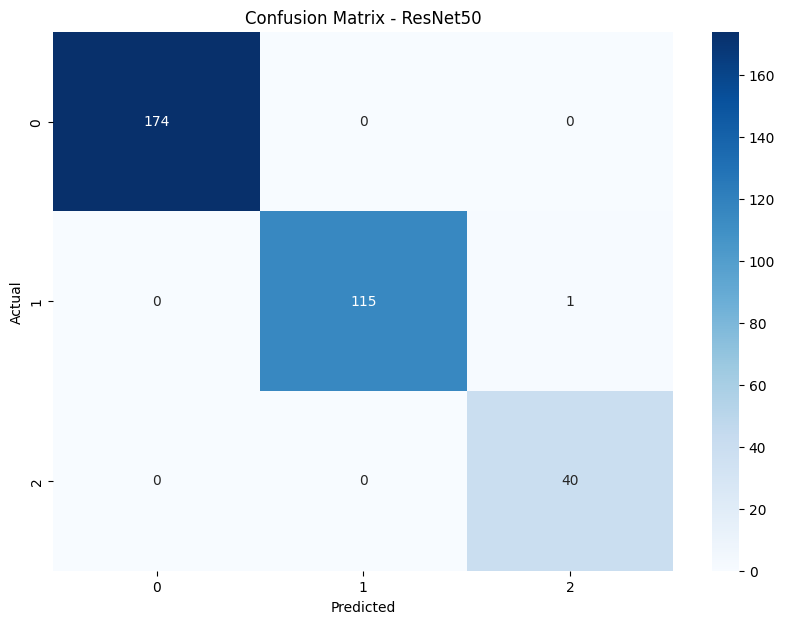

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(test.classes, pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet50")
plt.show()


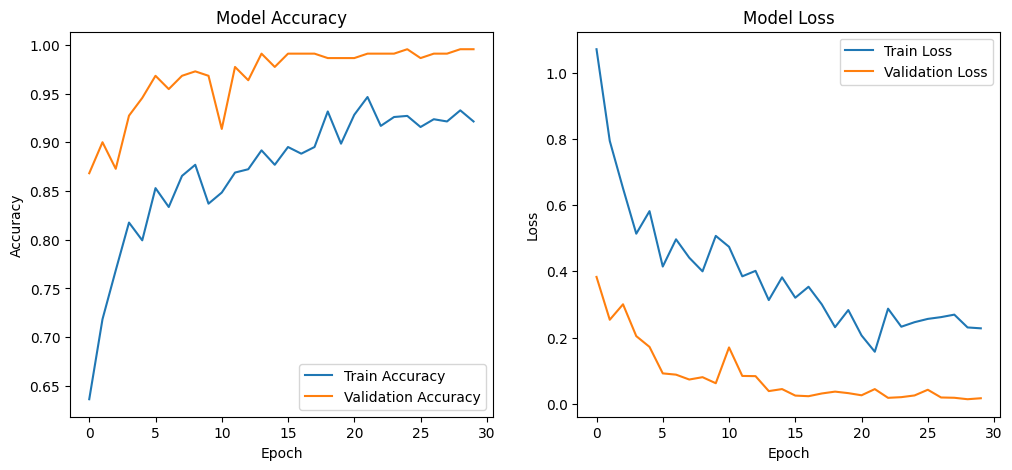

In [ ]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sample accuracy scores
accuracy = accuracy_score(y_test, pred2) * 100
densenet_accuracy = densenet_accuracy * 100
EfficientNetB3_accuracy = EfficientNetB3_accuracy * 100
ResNet50_accuracy = ResNet50_accuracy * 100

# Plot accuracies
models = ["Baseline Model", "DenseNet", "EfficientNetB3", "ResNet50"]
accuracies = [accuracy, densenet_accuracy, EfficientNetB3_accuracy, ResNet50_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracies Comparison")
plt.ylim(0, 100)

# Display values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=10)

plt.show()